In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [175]:
mwig_df = pd.read_csv('mwig40.csv', parse_dates['Data'])

In [178]:
mwig_df['day_change'] = ((wig_df['Zamkniecie'] / wig_df['Zamkniecie'].shift(1) ) - 1 ) * 100

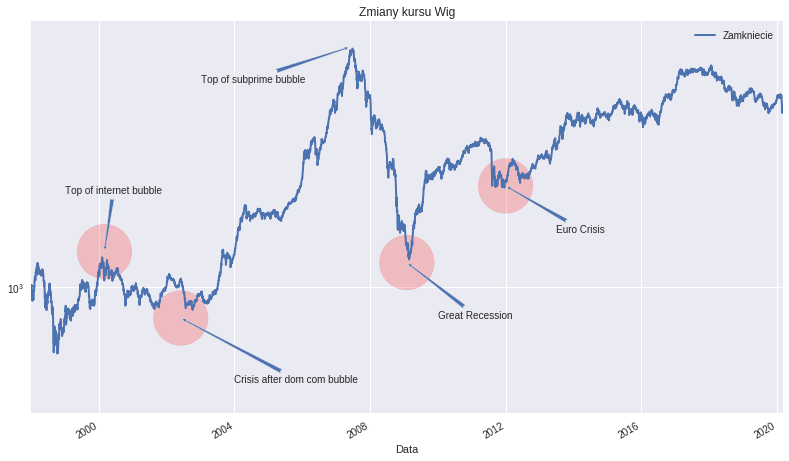

In [228]:
ax = plt.axes()

mwig_df.plot(x='Data', y='Zamkniecie', linewidth=2, figsize=[12, 8], ax=ax)

ax.set_title('Zmiany kursu Wig')
ax.set_ylim(400, 7000)
ax.set_yscale('log')

arrow_props = {'arrowstyle': 'fancy'}
annotates = [
    ['Top of internet bubble', [pd.Timestamp(2000, 3, 1),1300], [pd.Timestamp(1999, 1, 1), 2000]],
    ['Crisis after dom com bubble', [pd.Timestamp(2002, 6, 1), 800], [pd.Timestamp(2004,1,1), 500]],
    ['Top of subprime bubble', [pd.Timestamp(2007, 6, 1), 5800], [pd.Timestamp(2003, 1, 1), 4500]],
    ['Great Recession', [pd.Timestamp(2009, 2, 1), 1200], [pd.Timestamp(2010, 1, 1), 800]],
    ['Euro Crisis', [pd.Timestamp(2012, 1, 1), 2100], [pd.Timestamp(2013, 6, 30), 1500]]
]
for row in annotates:
    ax.annotate(row[0], xy=row[1], xytext=row[2], arrowprops=arrow_props)

extra_dots = np.array([
    [pd.Timestamp(2000, 3, 1),1300, 'red'],
    [pd.Timestamp(2002, 6, 1), 800, 'red'],
    [pd.Timestamp(2009, 2, 1), 1200, 'red'],
    [pd.Timestamp(2012, 1, 1), 2100, 'red'],
])
ax.scatter(extra_dots[:, 0], extra_dots[:,1], s=3000, alpha=0.2, c=extra_dots[:,2])

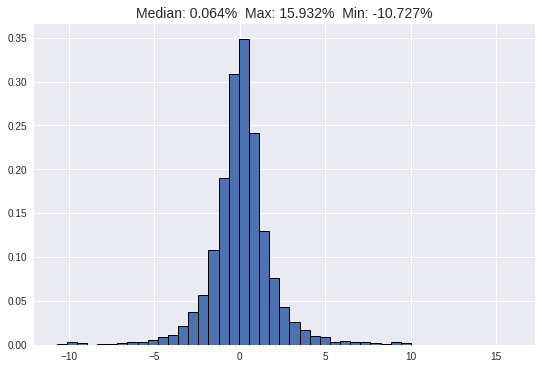

In [201]:
mediana = mwig_df['day_change'].median()
maximum = mwig_df['day_change'].max()
minimum = mwig_df['day_change'].min()
title = f'Median: {mediana:.3f}%  Max: {maximum:.3f}%  Min: {minimum:.3f}%'
ax = mwig_df['day_change'].hist(bins=45, density=True, edgecolor='black', linewidth=1)
ax.set_title(title, fontsize=14);